# Gene Expression Level Analysis Using nanoString Data

In this Jupyter notebook, we are providing the code for the analysis of nanoString data, and we are integrating this data with survival information, our digital marker scores, and immunohistochemistry (IHC) manual annotations for five markers, creating a comprehensive framework for our investigation. By amalgamating these diverse datasets, we aim to uncover intricate relationships between gene expression patterns, survival outcomes, and the presence of specific markers.


## Methods


> **See Also**: For a more in-depth tour about statistical methods you can visit the following papers:
- z-Score: Cheadle C, Vawter MP, Freed WJ, Becker KG. Analysis of Microarray Data Using Z Score Transformation. J Mol Diagn. 2003 May;5(2):73–81
- PCA: Raychaudhuri S, Stuart JM, Altman RB. PRINCIPAL COMPONENTS ANALYSIS TO SUMMARIZE MICROARRAY EXPERIMENTS: APPLICATION TO SPORULATION TIME SERIES. Pac Symp Biocomput. 2000;455–66.
- Spearman correlation: Guo Y, Sheng Q, Li J, Ye F, Samuels DC, Shyr Y. Large Scale Comparison of Gene Expression Levels by Microarrays and RNAseq Using TCGA Data. PLOS ONE. 2013 Aug 20;8(8):e71462
- Bonferroni correction: Armstrong RA. When to use the Bonferroni correction. Ophthalmic and Physiological Optics. 2014;34(5):502–8
- CoxPh: Lin DY, Wei LJ. The Robust Inference for the Cox Proportional Hazards Model. Journal of the American Statistical Association
- GSEA: Subramanian A, Tamayo P, Mootha VK, Mukherjee S, Ebert BL, Gillette MA, et al. Gene set enrichment analysis: A knowledge-based approach for interpreting genome-wide expression profiles. Proceedings of the National Academy of Sciences. 2005 Oct 25;102(43):15545–50


## Data

- For our analysis we used two techniques to fairly apply our methods due to its limitation:
    - Bootstrap resampling
    - k-fold cross-validation

### **python** libraries:
 -lifelines
 -pandas
 -sklearn

In [9]:
import numpy as np
from lifelines import CoxPHFitter
from lifelines.utils import k_fold_cross_validation
import pandas as pd
from scipy.stats import zscore
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr
from statsmodels.stats.multitest import multipletests
from sklearn.preprocessing import LabelEncoder


Reading the csv files for all the data that we are going to analyze

In [10]:
#clinical information
clinical_info = pd.read_csv("datasets/clinical.csv")
survival_outcomes = pd.read_csv("datasets/survival_outcomes.csv")

#nanoString related data
nanoString_data = pd.read_csv("datasets/nanoString_gene_expression_levels.csv")
nanoString_genes_descriptions = pd.read_csv("datasets/genes_descriptions.csv")
nanoString_pathways = pd.read_csv("datasets/nanoString_pathways_gene_association_original.csv")
nanoString_PAM50 = pd.read_csv("datasets/PAM50.csv")

#Digital scores related data
digital_scores = pd.read_csv("datasets/digi_scores.csv")

#GSEA related data
GSEA_pathways_all = pd.read_csv("datasets/GSEA_all.csv")
GSEA_pathways_Digi_sTILs = pd.read_csv("datasets/GSEA_Digi_sTILs.csv")
GSEA_pathways_Digi_TAS = pd.read_csv("datasets/GSEA_Digi_TAS.csv")

#TMA scores data
TMA_raw_scores = pd.read_csv("datasets/TMA_raw_scores.csv")
TMA_averaged_scores = pd.read_csv("datasets/TMA_scores_av.csv")
TMA_binary = pd.read_csv("datasets/TMA_binary.csv")

Pre-processing the nanoString gene expression levels with z-score and PCA

In [11]:
#remove the IDs
nanoString_data_temp = nanoString_data.drop(['ID'], axis=1)
#apply zscore
nanoString_data_zscore_temp = nanoString_data_temp.apply(zscore)


To choose the best number of components for PCA using all genes we will apply some determination methods

In [12]:
def pca_variance(dataset, n_components=0.85):
    pca = PCA(n_components=n_components)
    pca_variance_test = pd.DataFrame(data=pca.fit_transform(dataset))
    PCA_cols = []
    for i in range(0, pca.n_components_):
        PCA_cols.append('PCA_' + str(i + 1))

    pca_variance = pd.DataFrame(data=pca.fit_transform(dataset), columns=PCA_cols)

    return pca_variance

In [13]:
# ------------- Scree Plot---------------
def scree_plot(dataset):
    pca = PCA(n_components=20)

    pca.fit_transform(dataset)
    PC_values = np.arange(pca.n_components_) + 1
    plt.plot(PC_values, pca.explained_variance_ratio_, 'ro-', linewidth=2)
    plt.title('Scree Plot')
    plt.xlabel('Principal Component')
    plt.ylabel('Proportion of Variance Explained')
    plt.show()

In [14]:
# --------- PCA Variance  -------------
# we could set the variance to be 85%
nanoString_raw_pca_variance = pca_variance(nanoString_data_temp, n_components=0.85)
# --------- PCA Variance with z-score -------------
nanoString_z_score_pca_variance = pca_variance(nanoString_data_zscore_temp, n_components=0.85)


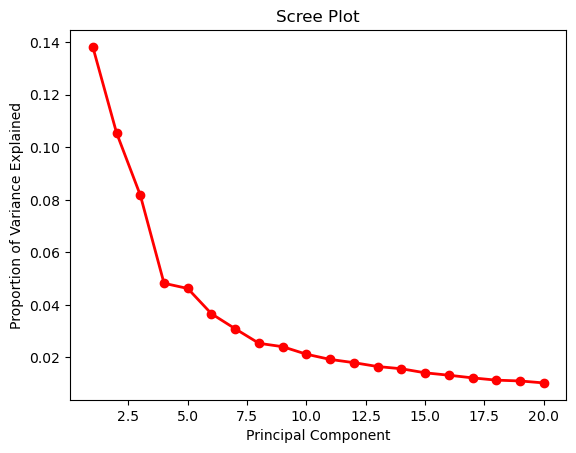

In [15]:
# --------- Scree plot with z_score -------------
pca = PCA(n_components=20)
Principal_components = pca.fit_transform(nanoString_data_temp)

# ------------- Scree Plot---------------
PC_values = np.arange(pca.n_components_) + 1
plt.plot(PC_values, pca.explained_variance_ratio_, 'ro-', linewidth=2)
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Proportion of Variance Explained')
plt.show()

In [16]:
# the scree plot show the best number of PCA components is 5
pca = PCA(n_components=5)
PCA_cols = []
for i in range(0, 5):
    PCA_cols.append('PCA_' + str(i + 1))

nanoString_pca_scree = pd.DataFrame(data=pca.fit_transform(nanoString_data_temp), columns=PCA_cols)
nanoString_z_score_pca_scree = pd.DataFrame(data=pca.fit_transform(nanoString_data_zscore_temp), columns=PCA_cols)


In [17]:
#add IDs to genes pca datasets
nanoString_data_IDs = [nanoString_data.loc[:, ['ID']], nanoString_data_zscore_temp]
nanoString_data_zscore = pd.concat(nanoString_data_IDs, axis=1, join='inner')

nanoString_data_IDs = [nanoString_data.loc[:, ['ID']], nanoString_raw_pca_variance]
nanoString_raw_pca_variance = pd.concat(nanoString_data_IDs, axis=1, join='inner')

nanoString_data_IDs = [nanoString_data.loc[:, ['ID']], nanoString_z_score_pca_variance]
nanoString_z_score_pca_variance = pd.concat(nanoString_data_IDs, axis=1, join='inner')

nanoString_data_IDs = [nanoString_data.loc[:, ['ID']], nanoString_pca_scree]
nanoString_pca_scree = pd.concat(nanoString_data_IDs, axis=1, join='inner')

nanoString_pca_scree.to_csv('nanoString_pca_scree.txt', sep='\t', index=False)

nanoString_data_IDs = [nanoString_data.loc[:, ['ID']], nanoString_z_score_pca_scree]
nanoString_z_score_pca_scree = pd.concat(nanoString_data_IDs, axis=1, join='inner')


In [18]:
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage


def hierarchical_clustering(data, cluster_number=2):
    # create a linkage matrix
    Z = linkage(data, method='ward', metric='euclidean')
    fig = plt.figure(figsize=(10, 5))
    dn = dendrogram(Z)
    plt.title('Heierarchical Clustering')
    plt.savefig('heierarchical.png')
    plt.show()


def k_mean_clustering(data, n_clusters=3):
    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(data)

    # Get the cluster assignments for each sample
    labels = kmeans.labels_

    u_labels = np.unique(labels)

    # Plot the clusters in 2D
    plt.scatter(data[:, 0], data[:, 1], c=labels)

    # plotting the results:
    for i in u_labels:
        # filter rows of original data
        filtered_label = data[labels == i]

        # Plotting the results
        plt.scatter(filtered_label[:, 0], filtered_label[:, 1], label=i)

        # plt.scatter(df[labels == i, 0], df[labels == i, 1], label=i)

    plt.title('K-Means Clustering')
    plt.savefig('k_mean.png')
    plt.show()

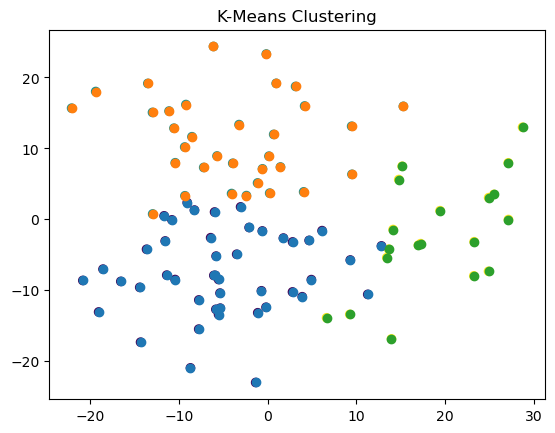

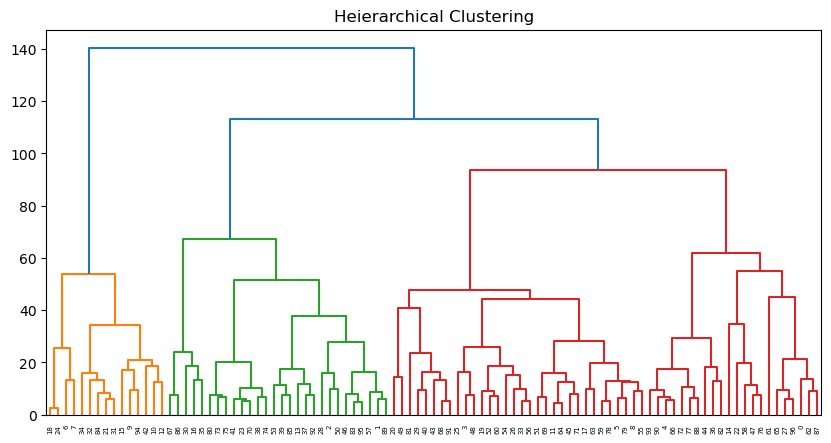

In [19]:
data_temp = nanoString_pca_scree.drop(['ID'], axis=1)
k_mean_clustering(data_temp.to_numpy(), n_clusters=3)
hierarchical_clustering(data_temp, cluster_number=3)



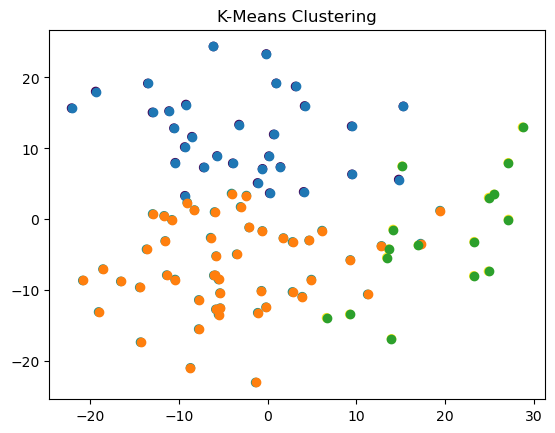

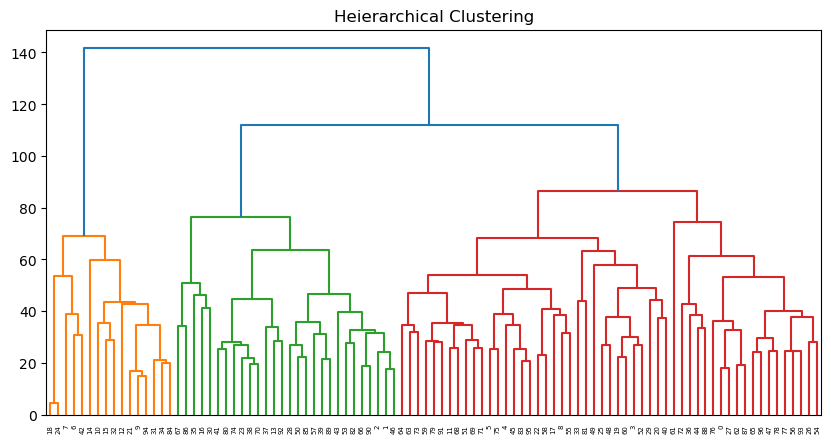

In [20]:
data_temp = nanoString_raw_pca_variance.drop(['ID'], axis=1)
k_mean_clustering(data_temp.to_numpy(), n_clusters=3)
hierarchical_clustering(data_temp, cluster_number=3)

In [21]:
def merge_two_datasets(data_one, data_two, ID='ID'):
    all_list = []
    for index, row in data_one.iterrows():
        list_ = []
        for IHC_index, IHC_row in data_two.iterrows():
            if IHC_row[ID] == row[ID]:
                for column, value in row.items():
                    list_.append(value)
                for column_, value_ in IHC_row.items():
                    if not (column_ == ID):
                        list_.append(value_)
                all_list.append(list_)

    first_dataset_cols = data_one.columns.tolist()
    second_dataset_cols = data_two.columns.tolist()
    second_dataset_cols.remove(ID)
    final_cols = first_dataset_cols
    final_cols.extend(second_dataset_cols)

    final_dataset = pd.DataFrame(all_list, columns=final_cols)

    return final_dataset

In [22]:
columns_nanoString = ['ID', 'AR', 'CLDN3', 'EGFR', 'KRT14', 'KRT5', 'CDH1']
nanoString_data_IHC = nanoString_data[columns_nanoString]

IHC_manual_annotation_nanoString_related_genes = merge_two_datasets(nanoString_data_IHC, TMA_averaged_scores)

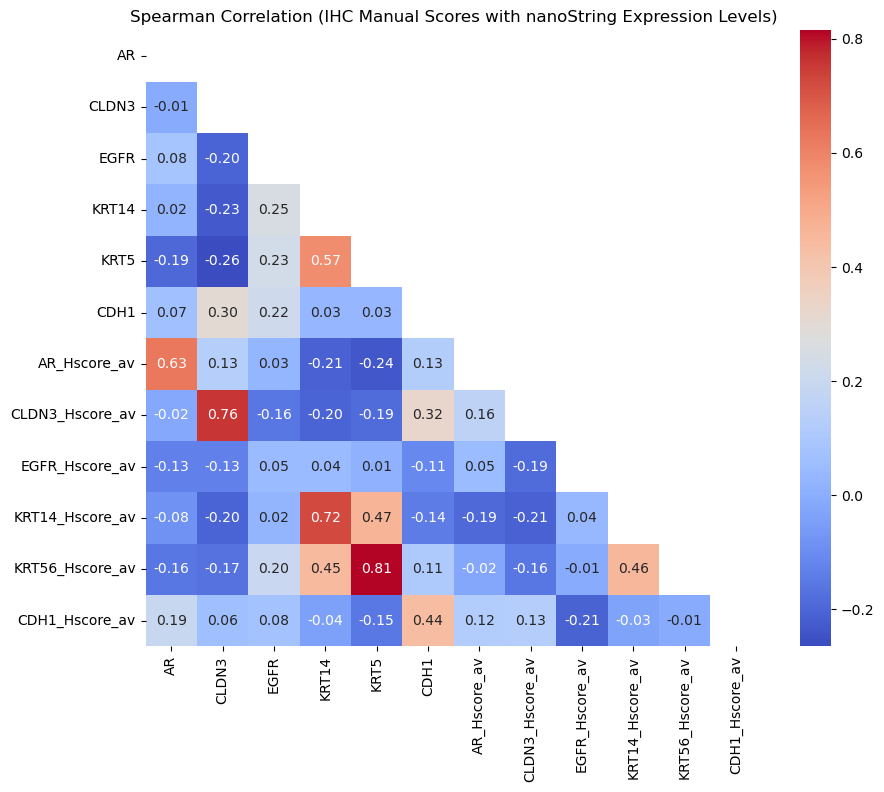

In [23]:
# Calculate Spearman correlation matrix
corr_matrix = IHC_manual_annotation_nanoString_related_genes.corr(method='spearman')

# Create a mask for the upper triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Create a heatmap with only the lower triangular part
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", square=True, mask=mask)
plt.title('Spearman Correlation (IHC Manual Scores with nanoString Expression Levels)')
plt.savefig('plots/IHC_nanoString_Spearman.png')
plt.show()

In [24]:
columns_nanoString = ['ID', 'AR', 'CDH1', 'CLDN3', 'EGFR', 'KRT14', 'KRT5']
nanoString_data_IHC = nanoString_data[columns_nanoString]

IHC_binary_annotation_nanoString_related_genes = merge_two_datasets(nanoString_data_IHC, TMA_binary)

print(len(IHC_binary_annotation_nanoString_related_genes))



84


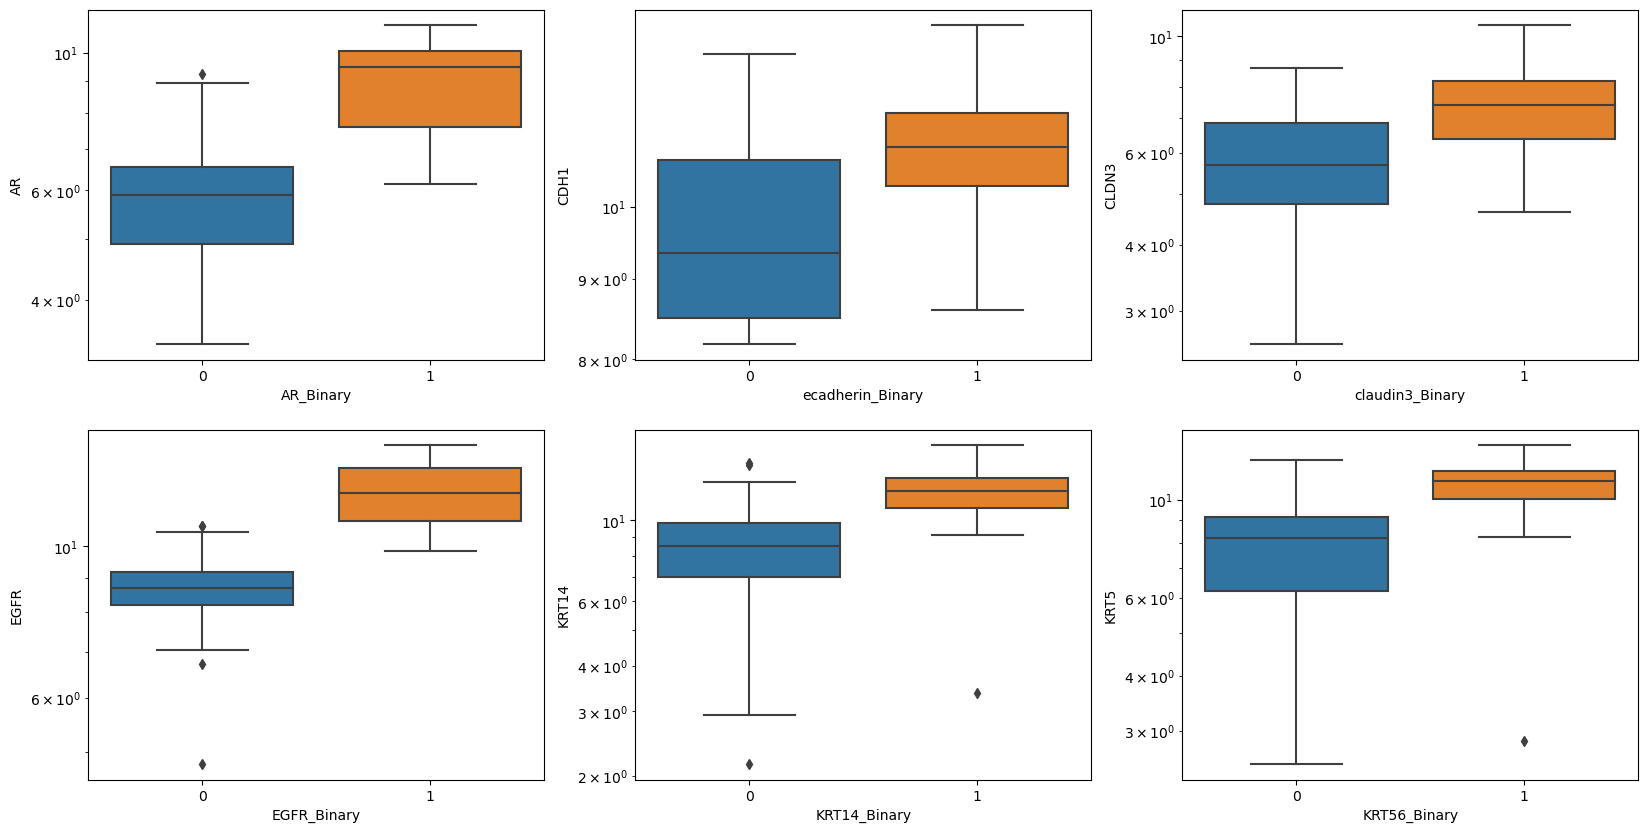

In [25]:
# Create a boxplot of different variables side by side
plt.figure(figsize=(20, 10))
continues_list = ['AR', 'CDH1', 'CLDN3', 'EGFR', 'KRT14', 'KRT5']
binary_list = TMA_binary.columns.tolist()
binary_list.remove('ID')

for i, c in enumerate(continues_list, 1):
    plt.subplot(2, 3, i)
    g = sns.boxplot(x=binary_list[i - 1], y=c, data=IHC_binary_annotation_nanoString_related_genes)
    g.set(yscale="log")
plt.savefig('plots/binary_IHC_nanoString.png')


In [26]:
IHC_PAM50 = merge_two_datasets(nanoString_PAM50, TMA_averaged_scores)
print(len(IHC_PAM50))

83


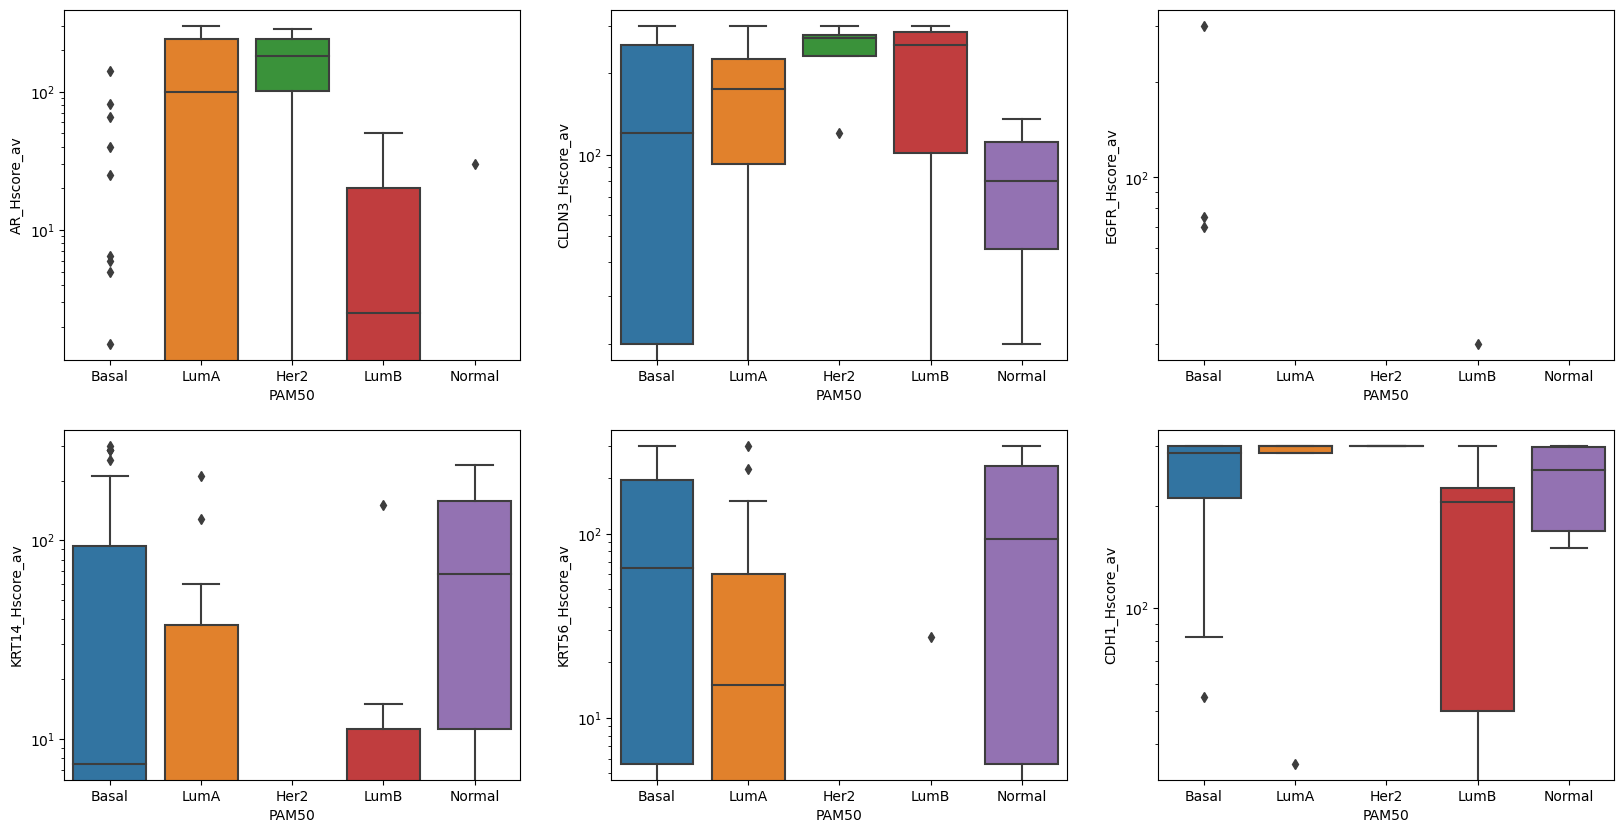

In [27]:
plt.figure(figsize=(20, 10))
continues_list = IHC_PAM50.columns.tolist()

continues_list.remove('PAM50')
continues_list.remove('ID')

for i, c in enumerate(continues_list, 1):
    plt.subplot(2, 3, i)
    g = sns.boxplot(x='PAM50', y=c, data=IHC_PAM50)
    g.set(yscale="log")
#plt.savefig('plots/binary_IHC_nanoString.png')

In [28]:
PAM50_digital_scores = merge_two_datasets(nanoString_PAM50, digital_scores)


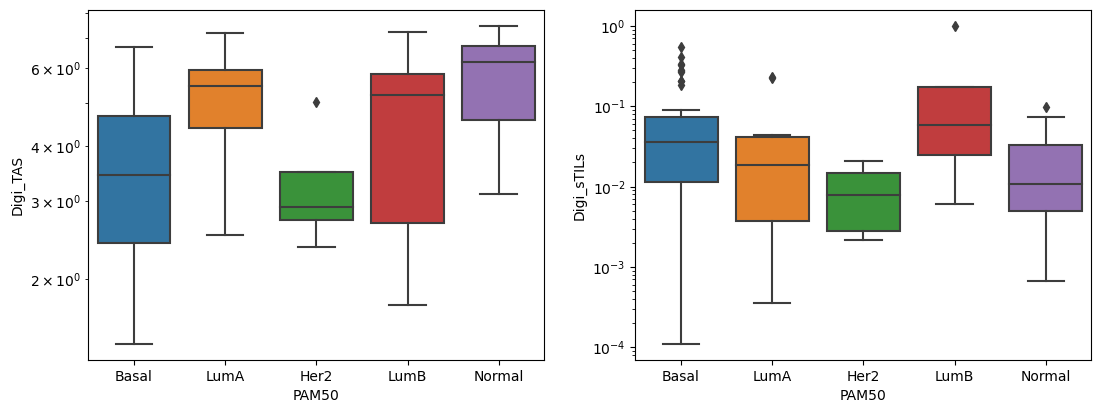

In [29]:
plt.figure(figsize=(20, 10))
column_lists = ['Digi_TAS', 'Digi_sTILs']
for i, c in enumerate(column_lists, 1):
    plt.subplot(2, 3, i)
    g = sns.boxplot(x='PAM50', y=c,
                    data=PAM50_digital_scores)
    g.set(yscale="log")

plt.savefig('plots/pam50_DigiScore.png')



To combine the data from the two CSV files based on the IDs

In [30]:
digi_scores_nanoString_gene_expression_levels = merge_two_datasets(nanoString_data, digital_scores)


In [31]:
# List of genes
gene_lists = digi_scores_nanoString_gene_expression_levels.columns.tolist()
gene_lists.remove('ID')
gene_lists.remove('Digi_sTILs')
gene_lists.remove('Digi_TAS')

To apply Spearman correlation with Bonferroni correction

In [32]:
## calculate correlation for Digi-sTILs scores
p_values = []
r_values = []
features = []

digital_scores_column = digi_scores_nanoString_gene_expression_levels['Digi_sTILs']
for gene in gene_lists:
    # Replace this line with actual gene expression data retrieval
    gene_data = digi_scores_nanoString_gene_expression_levels[gene]

    # Calculate Pearson correlation coefficient and p-value
    r, p = spearmanr(gene_data, digital_scores_column)

    # Append results to list_s
    r_values.append(r)
    p_values.append(p)
    features.append(gene)

# Correct p-values using Bonferroni correction
alpha = 0.05  # Set your desired significance level
n_tests = len(gene_lists)
corrected_p_values = multipletests(p_values, method='bonferroni')[1]

# Create a pandas DataFrame to display the results as a table
result_df = pd.DataFrame({
    'Gene': features,
    'Spearman Correlation (r)': r_values,
    'Uncorrected p-value': p_values,
    'Bonferroni Corrected p-value': corrected_p_values
})

# Display the table
result_df.to_csv('correlation_nanoString_Digi_sTILs.csv')

In [33]:
## calculate correlation for Digi-TAS scores
p_values = []
r_values = []
features = []

digital_scores_column = digi_scores_nanoString_gene_expression_levels['Digi_TAS']
for gene in gene_lists:
    # Replace this line with actual gene expression data retrieval
    gene_data = digi_scores_nanoString_gene_expression_levels[gene]

    # Calculate Pearson correlation coefficient and p-value
    r, p = spearmanr(gene_data, digital_scores_column)

    # Append results to list_s
    r_values.append(r)
    p_values.append(p)
    features.append(gene)

# Correct p-values using Bonferroni correction
n_tests = len(gene_lists)
corrected_p_values = multipletests(p_values, method='bonferroni')[1]

# Create a pandas DataFrame to display the results as a table
result_df = pd.DataFrame({
    'Gene': features,
    'Spearman Correlation (r)': r_values,
    'Uncorrected p-value': p_values,
    'Bonferroni Corrected p-value': corrected_p_values
})

# Display the table
result_df.to_csv('correlation_nanoString_Digi_TAS.csv')

To perform the survival analysis with different patient data using bootstrapping and sampling with overall survival and disease specific survival

In [110]:
def survival_with_k_folds(data, penalizer=0.0, scoring_method='concordance_index', num_folds=10):
    # Create a Cox Proportional-Hazards model
    cph = CoxPHFitter(penalizer=penalizer)

    # Perform k-fold cross-validation
    results = k_fold_cross_validation(cph, data, 'time', event_col='event'
                                      , scoring_method=scoring_method, k=num_folds)

    # Print results for each fold
    # for i, result in enumerate(results):
    #     print(f"Fold {i + 1} C-index (concordance index): {result:.3f}")
    #

    # Calculate and print the mean and std for C-index across all folds
    mean_c_index = np.mean(results)
    std_c_index = np.std(results)
    # print(f"\nMean C-index across all folds: {mean_c_index:.3f}")
    # print(f"\nSTD C-index across all folds: {std_c_index:.3f}")

    return mean_c_index, std_c_index

In [35]:
# using clinical with DSS, OS and k-folds
dataset = merge_two_datasets(survival_outcomes, clinical_info)

event_col = 'DSS'
dataset = dataset.loc[:,
          ['time', event_col, 'age', 'Axillary nodes Flag', 'Sentinel nodes Flag', 'tumour_size']]

dataset = dataset.rename(columns={event_col: 'event'})
#check for nans and drop the row that contains it
df = dataset.dropna()

# Look at the categorical and numerical variables
summary_categorical = []
for column in df.columns:
    if df[column].dtype == object:
        summary_categorical.append(column)
        print(df[column].value_counts())
        print(f"----------------------------------")

summary_numerical = []
for column in df.columns:
    if df[column].dtype != object:
        print(f"{column} : Minimum: {min((df[column].unique()))}, Maximum: {max((df[column].unique()))} ")
        summary_numerical.append(column)
        print(f"----------------------------------")

# Convert all string categorical variables into integer labels
encoder = LabelEncoder()
# Convert string categorical variables into integer labels
categorical_columns = df.select_dtypes(include=['object'])
for column in categorical_columns.columns:
    df[column] = encoder.fit_transform(df[column])

print(f"The number of sampels:{len(df)}")

survival_with_k_folds(df)

time : Minimum: 0, Maximum: 273 
----------------------------------
event : Minimum: 0, Maximum: 1 
----------------------------------
age : Minimum: 26, Maximum: 93 
----------------------------------
Axillary nodes Flag : Minimum: 0, Maximum: 1 
----------------------------------
Sentinel nodes Flag : Minimum: 0, Maximum: 1 
----------------------------------
tumour_size : Minimum: 2.0, Maximum: 150.0 
----------------------------------
The number of sampels:358

Mean C-index across all folds: 0.741

STD C-index across all folds: 0.080


(0.7409449915090597, 0.07991627198658088)

In [36]:
# using Digi-TAS and Digi-sTILs with DSS, OS and k-folds
dataset = merge_two_datasets(survival_outcomes, digital_scores)

event_col = 'DSS'
dataset = dataset.loc[:,
          ['time', event_col, 'Digi_sTILs', 'Digi_TAS']]

dataset = dataset.rename(columns={event_col: 'event'})
#check for nans and drop the row that contains it
df = dataset.dropna()

print(f"The number of sampels:{len(df)}")

survival_with_k_folds(df)

The number of sampels:319

Mean C-index across all folds: 0.655

STD C-index across all folds: 0.125


(0.655044283075422, 0.12536369216725599)

In [78]:
# using IHC markers with DSS, OS, and k-folds
dataset = merge_two_datasets(survival_outcomes, TMA_averaged_scores)
event_col = 'DSS'
dataset = dataset.loc[:,
          ['time', event_col, 'AR_Hscore_av', 'CLDN3_Hscore_av', 'KRT14_Hscore_av', 'KRT56_Hscore_av',
           'CDH1_Hscore_av']]

dataset = dataset.rename(columns={event_col: 'event'})
#check for nans and drop the row that contains it
df = dataset.dropna()

print(f"The number of sampels:{len(df)}")

survival_with_k_folds(df, num_folds=5)

The number of sampels:219

Mean C-index across all folds: 0.373

STD C-index across all folds: 0.058


(0.37291084923752504, 0.05816324580971604)

In [83]:
temp = nanoString_z_score_pca_scree.drop(['ID'], axis=1)

dataset = merge_two_datasets(survival_outcomes, nanoString_z_score_pca_scree)

event_col = 'DSS'
selected_cols = temp.columns.tolist()
selected_cols.extend(['time', event_col])

dataset = dataset.loc[:, selected_cols]

dataset = dataset.rename(columns={event_col: 'event'})
#check for nans and drop the row that contains it
df = dataset.dropna()

print(f"The number of samples: {len(df)}")

survival_with_k_folds(df, penalizer=0.0, num_folds=3)

The number of samples: 96

Mean C-index across all folds: 0.546

STD C-index across all folds: 0.091


(0.5463450292397661, 0.0907914747733628)

In [100]:
#All features
dataset_nano = merge_two_datasets(survival_outcomes, nanoString_z_score_pca_scree)

dataset_nano_TMA = merge_two_datasets(dataset_nano, TMA_averaged_scores)

dataset_nano_TMA_digi = merge_two_datasets(dataset_nano_TMA, digital_scores)

dataset_nano_TMA_digi_clinical = merge_two_datasets(dataset_nano_TMA_digi, clinical_info)

# Convert all string categorical variables into integer labels
encoder = LabelEncoder()
# Convert string categorical variables into integer labels
categorical_columns = dataset_nano_TMA_digi_clinical.select_dtypes(include=['object'])
for column in categorical_columns.columns:
    dataset_nano_TMA_digi_clinical[column] = encoder.fit_transform(dataset_nano_TMA_digi_clinical[column])

event_col = 'DSS'

selected_cols = ['time', event_col, 'PCA_1', 'PCA_2',
                 'PCA_3', 'PCA_4', 'PCA_5', 'Axillary nodes Flag'
    , 'Sentinel nodes Flag', 'tumour_size', 'age', 'Digi_sTILs', 'Digi_TAS', 'AR_Hscore_av', 'CLDN3_Hscore_av',
                 'KRT14_Hscore_av', 'KRT56_Hscore_av']

dataset_nano_TMA_digi_clinical_temp = dataset_nano_TMA_digi_clinical.loc[:, selected_cols]

dataset_nano_TMA_digi_clinical_temp = dataset_nano_TMA_digi_clinical_temp.rename(columns={event_col: 'event'})

dataset_nano_TMA_digi_clinical_temp = dataset_nano_TMA_digi_clinical_temp.dropna()

print(f"The number of samples: {len(dataset_nano_TMA_digi_clinical_temp)}")

survival_with_k_folds(dataset_nano_TMA_digi_clinical_temp, penalizer=0.0, num_folds=3)

The number of samples: 75

Mean C-index across all folds: 0.568

STD C-index across all folds: 0.125


(0.5679731914671673, 0.12481084077107554)

Perform survival analysis using the gene sets from the associated terms using nanoString provided pathways

In [101]:

# pathways_cols = nanoString_pathways.columns.tolist()
# pathways_cols.remove('gene_symbol')
# pathways_cols.remove('entrez_ID')
#
# for item in pathways_cols:
#     gene_lists = ['ID']
#     print(item)
#     for index, row in nanoString_pathways.iterrows():
#         value = row[item]
#         if value > 0:
#             gene_lists.append(row['gene_symbol'])
#
#     nanoString_data_temp = nanoString_data_zscore.loc[:, gene_lists]
#
#     pathway_clinical_genes = merge_two_datasets(nanoString_data_temp, survival_outcomes)
#
#     event_col = 'OS'
#     pathway_clinical_genes = pathway_clinical_genes.rename(columns={event_col: 'event'})
#
#     gene_lists.remove('ID')
#     gene_lists.append('time')
#     gene_lists.append('event')
#
#     pathway_clinical_genes_temp = pathway_clinical_genes.loc[:, gene_lists]
#     #print(pathway_clinical_genes)
#
#     #survival_with_k_folds(pathway_clinical_genes, penalizer=0.0)
#
#     # pca = PCA(n_components=2)
#     # PCA_cols = []
#     # for i in range(0, 2):
#     #     PCA_cols.append('PCA_' + str(i + 1))
#     #
#     # pathway_clinical_genes_PCA = pd.DataFrame(data=pca.fit_transform(pathway_clinical_genes_temp), columns=PCA_cols)
#
#     survival_with_k_folds(pathway_clinical_genes_temp)


In [109]:

terms_value = []
genes_list = []
raw_c_indices = []
raw_stds = []
z_score_c_indices = []
z_score_stds = []

nanoString_survival_temp = merge_two_datasets(nanoString_data, survival_outcomes)
nanoString_zscore_survival_temp = merge_two_datasets(nanoString_data_zscore, survival_outcomes)

for index, row in GSEA_pathways_all.iterrows():
    try:
        event_col = 'OS'
        genes = ['time', event_col]
        term_gene_list = row['Genes'].split(';')

        for item in term_gene_list:
            genes.append(item)

        nanoString_survival_temp_gene_lists = nanoString_survival_temp.loc[:, genes]

        nanoString_zscore_survival_temp_gene_lists = nanoString_zscore_survival_temp.loc[:, genes]

        nanoString_survival_temp_gene_lists = nanoString_survival_temp_gene_lists.rename(columns={event_col: 'event'})

        nanoString_zscore_survival_temp_gene_lists = nanoString_zscore_survival_temp_gene_lists.rename(
            columns={event_col: 'event'})

        cof, std = survival_with_k_folds(nanoString_survival_temp_gene_lists, num_folds=3, penalizer=0.001)
        cof_, std_ = survival_with_k_folds(nanoString_zscore_survival_temp_gene_lists, num_folds=3, penalizer=0.001)

        terms_value.append(row['Term'])
        genes_list.append(row['Genes'])
        raw_c_indices.append(cof)
        raw_stds.append(std)
        z_score_c_indices.append(cof_)
        z_score_stds.append(std_)

        result_df = pd.DataFrame({
            'Terms': terms_value,
            'Genes': genes_list,
            'Raw c indices': raw_c_indices,
            'Raw std': raw_stds,
            'Z score c indices': z_score_c_indices,
            'Z score std': z_score_stds

        })

        result_df.to_csv('OS_GSEA_genes_all_pathways_c_indices.csv')

    except:
        pass


In [ ]:
terms_value = []
genes_list = []
raw_c_indices = []
z_score_c_indices = []
raw_stds = []
z_score_stds = []

pca = PCA(n_components=3)
PCA_cols = []
for i in range(0, 3):
    PCA_cols.append('PCA_' + str(i + 1))

nanoString_survival_temp = merge_two_datasets(nanoString_data, survival_outcomes)
nanoString_zscore_survival_temp = merge_two_datasets(nanoString_data_zscore, survival_outcomes)

event_col = 'DSS'

for index, row in GSEA_pathways_Digi_sTILs.iterrows():
    try:
        genes = ['time', event_col]
        genes_pca = []
        term_gene_list = row['Genes'].split(';')

        for item in term_gene_list:
            genes.append(item)
            genes_pca.append(item)

        nanoString_temp_gene_lists = nanoString_survival_temp.loc[:, genes]
        nanoString_zscore_survival_temp_gene_lists = nanoString_zscore_survival_temp.loc[:, genes]

        nanoString_temp_gene_lists = nanoString_temp_gene_lists.rename(columns={event_col: 'event'})
        nanoString_zscore_survival_temp_gene_lists = nanoString_zscore_survival_temp_gene_lists.rename(
            columns={event_col: 'event'})

        nanoString_temp_gene_lists_pca = pd.DataFrame(
            data=pca.fit_transform(nanoString_temp_gene_lists.loc[:, genes_pca]),
            columns=PCA_cols)

        nanoString_temp_gene_lists = [nanoString_temp_gene_lists.loc[:, ['time', 'event']],
                                      nanoString_temp_gene_lists_pca]

        nanoString_temp_gene_lists = pd.concat(nanoString_temp_gene_lists, axis=1, join='inner')

        nanoString_zscore_survival_temp_gene_lists_pca = pd.DataFrame(
            data=pca.fit_transform(nanoString_zscore_survival_temp_gene_lists.loc[:, genes_pca]), columns=PCA_cols)

        nanoString_zscore_survival_temp_gene_lists = [
            nanoString_zscore_survival_temp_gene_lists.loc[:, ['time', 'event']],
            nanoString_zscore_survival_temp_gene_lists_pca]

        nanoString_zscore_survival_temp_gene_lists = pd.concat(nanoString_zscore_survival_temp_gene_lists, axis=1,
                                                               join='inner')

        cof, std = survival_with_k_folds(nanoString_temp_gene_lists, num_folds=3)
        cof_, std_ = survival_with_k_folds(nanoString_zscore_survival_temp_gene_lists, num_folds=3)

        terms_value.append(row['Term'])
        genes_list.append(row['Genes'])
        raw_c_indices.append(cof)
        raw_stds.append(std)
        z_score_c_indices.append(cof_)
        z_score_stds.append(std_)

        result_df = pd.DataFrame({
            'Terms': terms_value,
            'Genes': genes_list,
            'Raw c indices': raw_c_indices,
            'Raw std': raw_stds,
            'Z score c indices': z_score_c_indices,
            'Z score std': z_score_stds
        })

        result_df.to_csv('DSS_pca_GSEA_genes_Digi_sTILs_pathways_c_indices.csv')
    except:
        pass
